In [1]:
#%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import math
import pickle

## SOME FUNCTIONS HAVE BEEN IMPLEMENTED in `estimated_related.py` since they needed to be used again and again

# 2. Two view Geometry

For this task, you have been given two images of the same scene taken from different view-points. Refer to below two images and follow the below points for deliverables:
<br>

*Note: For this question you will need to compute the F matrix on your own without using inbuilt functions. The convention used for F is $x'^{T}Fx$ where $x'$ is the **location of the point in the second image**. File `data/2/camera.txt` has camera parameters in order **Fx, Fy, Cx, Cy, Scaling factor***
<br>


<img src="./data/2/rgb000551.jpg" alt="image 1" width="400"/>
<img src="./data/2/rgb000841.jpg" alt="image 2" width="400"/>


1. Estimate the fundamental matrix from these two images. Clearly, write a function named `compute_fundamental_matrix(X1_list, X2_list)` that takes feature points from first image and corresponding points from second image i.e. known correspondences. You can compute the correspondences either using Feature detector-descriptor + Feature Matching algorithm from openCV or use code provided in DLT part i.e. handcraft them. Save the obtained matrix.

# TASKS

###  Generate the correspondences

In [2]:
import cv2
import importlib
import matplotlib.pyplot as plt
import json
from copy import deepcopy
import numpy as np

In [3]:
import helper_utils.dlt_related as dlt_related
importlib.reload(dlt_related)
import helper_utils.annotate_images as img_helper
importlib.reload(img_helper)
import helper_utils.estimation_related as est_related
importlib.reload(est_related)

<module 'helper_utils.estimation_related' from '/home/anmolagarwal/Desktop/mr_assignment_3/helper_utils/estimation_related.py'>

#### Load the pixel coordinates of 2 images
I generated these pixel coordinates using this tool: https://pixspy.com/ 

In [4]:
with open("him_1.json", 'r') as fd:
    px_df_1=json.load(fd)
    px_df_1 = [x.split(",") for x in px_df_1]
    px_df_1 = [[int(y) for y in x] for x in px_df_1]
with open("him_2.json", 'r') as fd:
    px_df_2=json.load(fd)
    px_df_2 = [x.split(",") for x in px_df_2]
    px_df_2 = [[int(y) for y in x] for x in px_df_2]

In [5]:
print("Number of labelled pixels in the images is: ", len(px_df_1), " and ",len(px_df_2 ))

Number of labelled pixels in the images is:  23  and  23


## Display the pixel mappings (corresponding pixels have been colored with the same color):

In [6]:
all_colors = img_helper.get_unique_colors(len(px_df_1))

In [7]:
img_1 = cv2.imread('./data/2/img_1.jpg')
img_2 = cv2.imread('./data/2/img_2.jpg')

##### Image 1

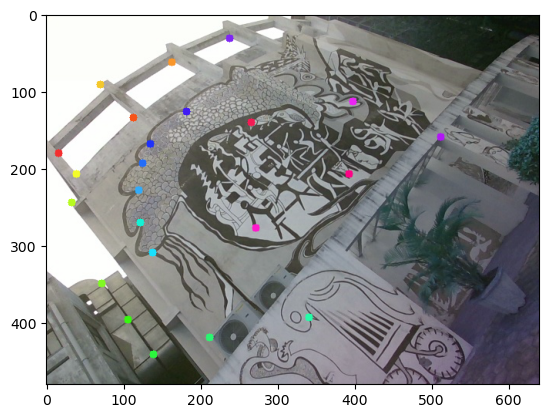

In [8]:
ans1 = img_helper.plot_diff_pixel_points(img_1, px_df_1, all_colors, circle_rad=5)
plt.imshow(ans1)

##### Image 2

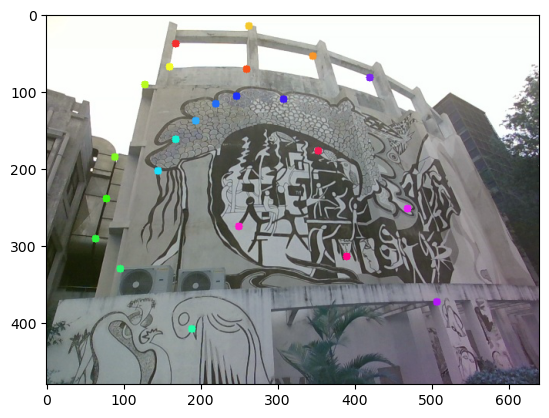

In [9]:
ans2 = img_helper.plot_diff_pixel_points(img_2, px_df_2, all_colors, circle_rad=5)
plt.imshow(ans2)

In [10]:
list(zip(px_df_1, px_df_2))

[([16, 180], [168, 38]),
 ([113, 134], [260, 71]),
 ([163, 62], [346, 54]),
 ([70, 91], [263, 15]),
 ([39, 207], [160, 68]),
 ([33, 244], [128, 91]),
 ([72, 349], [89, 185]),
 ([106, 396], [78, 239]),
 ([139, 441], [64, 291]),
 ([212, 419], [96, 330]),
 ([341, 393], [189, 408]),
 ([122, 270], [168, 162]),
 ([138, 309], [145, 203]),
 ([120, 228], [194, 138]),
 ([125, 193], [220, 116]),
 ([135, 168], [247, 106]),
 ([182, 126], [308, 110]),
 ([238, 31], [420, 82]),
 ([512, 159], [507, 373]),
 ([398, 113], [469, 252]),
 ([272, 277], [250, 275]),
 ([393, 207], [390, 314]),
 ([266, 140], [353, 177])]

In [11]:
def homogenize_2d_coordinates(pts_list):
    """Takes a list of 2d points and simply appends 1 to it"""
    new_list = deepcopy(pts_list)
    for curr_elem in new_list:
        curr_elem.append(1)
    new_list = np.array(new_list)
    return new_list

### Starting fundamental matrix estimation

My implementation is based on algorithm 11.1 of Zisserman's book.

As mentioned in **Fei Fei Li's slides**, normalizing the pixel coordinates before estimating fundamental matrix leads to more stable and less fluctuating solutions.
Implementation specifics have been mentioned here: https://www5.cs.fau.de/fileadmin/lectures/2014s/Lecture.2014s.IMIP/exercises/4/exercise4.pdf 

### STEP 1: Pixel value normalization

##### Below, we calculate the normal pixel values and the matrix with which we multiplied the original pixels to normalize them

In [12]:
norm_px_1, norm_matrix_1 = est_related.normalize_2d_coordinates(px_df_1)
norm_px_2, norm_matrix_2 = est_related.normalize_2d_coordinates(px_df_2)

Trying to normalize 2d coordinated for an array with 23 points
the mean is:  [182.82608696 223.34782609]
points after translatibg via the mean is ,  [[-166.82608696  -43.34782609]
 [ -69.82608696  -89.34782609]
 [ -19.82608696 -161.34782609]
 [-112.82608696 -132.34782609]
 [-143.82608696  -16.34782609]
 [-149.82608696   20.65217391]
 [-110.82608696  125.65217391]
 [ -76.82608696  172.65217391]
 [ -43.82608696  217.65217391]
 [  29.17391304  195.65217391]
 [ 158.17391304  169.65217391]
 [ -60.82608696   46.65217391]
 [ -44.82608696   85.65217391]
 [ -62.82608696    4.65217391]
 [ -57.82608696  -30.34782609]
 [ -47.82608696  -55.34782609]
 [  -0.82608696  -97.34782609]
 [  55.17391304 -192.34782609]
 [ 329.17391304  -64.34782609]
 [ 215.17391304 -110.34782609]
 [  89.17391304   53.65217391]
 [ 210.17391304  -16.34782609]
 [  83.17391304  -83.34782609]]
[DEBUG] the mean of translated df is  [-9.88581198e-15  2.47145299e-15]
Tot dis from origin is:  3608.6234625867637
Scaling factor is:  0

In [13]:
with np.printoptions(suppress=True):
    print('\nNormalized pixel coordinates in image 1:\n', norm_px_1)
    print('\nNormalized pixel coordinates in image 2:\n', norm_px_2)


Normalized pixel coordinates in image 1:
 [[-1.50371395 -0.39072265  1.        ]
 [-0.62938874 -0.8053511   1.        ]
 [-0.17870565 -1.45433476  1.        ]
 [-1.01697621 -1.19293856  1.        ]
 [-1.29639972 -0.14735378  1.        ]
 [-1.3504817   0.18615171  1.        ]
 [-0.99894888  1.13258622  1.        ]
 [-0.69248438  1.55622833  1.        ]
 [-0.39503353  1.96184311  1.        ]
 [ 0.26296379  1.76354255  1.        ]
 [ 1.42572618  1.52918734  1.        ]
 [-0.54826578  0.42050692  1.        ]
 [-0.40404719  0.77203974  1.        ]
 [-0.56629311  0.04193312  1.        ]
 [-0.5212248  -0.27354504  1.        ]
 [-0.43108818 -0.49888659  1.        ]
 [-0.00744607 -0.87746039  1.        ]
 [ 0.497319   -1.73375828  1.        ]
 [ 2.96706237 -0.58000955  1.        ]
 [ 1.93950491 -0.994638    1.        ]
 [ 0.80378351  0.48360256  1.        ]
 [ 1.8944366  -0.14735378  1.        ]
 [ 0.74970153 -0.75126913  1.        ]]

Normalized pixel coordinates in image 2:
 [[-0.6649469  -1

In [14]:
num_points = norm_px_1.shape[0]
print("Number of annotated points is: ", num_points)

Number of annotated points is:  23


### Step 2: Fetching a linear solution

<img src="./docs/img_funda.png" alt="image 2" width="400"/>


#### Initializing and prepping A matrix for solving:
$$A_{mat}\:\:x\:\:flattened\_F = 0$$

In [15]:
A_mat = np.ones((num_points, 9))

In [16]:
for i in range(num_points):
    A_mat[i][0:3]*= norm_px_2[i][0] 
    A_mat[i][3:6]*= norm_px_2[i][1] 
    A_mat[i][::3]*= norm_px_1[i][0] 
    A_mat[i][1::3]*= norm_px_1[i][1] 

In [17]:
with np.printoptions(suppress=True):
    print("Sample row from A matrix is:\n ", A_mat[0])

Sample row from A matrix is:
  [ 0.99988992  0.25980981 -0.6649469   1.95609533  0.50826871 -1.30084271
 -1.50371395 -0.39072265  1.        ]


In [18]:
sol, U, S, V = est_related.fetch_best_solution(A_mat)

Given A matrix, trying to find best P_vector value where P has 9 dimensions


______________

`sol` is a contender for the flattened version of F matrix. In the below cell, I want to see if `A_mat` and `sol` are actually a good fit ie whether the elements of $$A_{mat}\:\:x\:\:sol === 0$$

#### Most of the array elements below are approaching 0 (sanity check)

In [19]:
A_mat@sol

array([ 0.00045801,  0.01055336, -0.00146244,  0.00444248, -0.01411001,
        0.00254804,  0.00841777,  0.00580565, -0.00511734, -0.00063073,
        0.00081758, -0.02074214,  0.00322676,  0.01149598, -0.00429805,
       -0.00263484,  0.00322715, -0.00606914,  0.00216464,  0.00016172,
        0.0015068 , -0.0057093 ,  0.00597257])

### STEP 3: Rank constraint reinforcement

#### Checking the rank of the current F matrix

In [20]:
from numpy.linalg import matrix_rank

In [21]:
F_old = deepcopy(sol)
F_old = F_old.reshape(3,3)

In [22]:
with np.printoptions(suppress=True):
    print(F_old)

[[-0.02233263 -0.01852273  0.06247117]
 [-0.00052653 -0.02451693  0.71000274]
 [-0.53958023 -0.44607215  0.02056879]]


In [23]:
print("rank of the initial F guess is: " , matrix_rank(F_old))

rank of the initial F guess is:  3


#### Computation to estimate a new fundamental matrix whose rank is "2" 
as mentioned in Fei Fei Li's slides and the Zisserman book

In [24]:
U, S, Vh = np.linalg.svd(F_old, full_matrices=False)

In [25]:
U.shape, Vh.shape

((3, 3), (3, 3))

In [26]:
S_new = deepcopy(S)

##### Setting all singular values except the first 2 to be zero

In [27]:
S_new[2:] = 0

In [28]:
S_new

array([0.72728962, 0.68632891, 0.        ])

#### Reconstructing the fundamental matrix with rank "2"

In [29]:
F_new = U@np.diag(S_new)@Vh

In [30]:
with np.printoptions(suppress=True):
    print(F_new)

[[-0.02134589 -0.01971838  0.06243091]
 [-0.00061217 -0.02441316  0.71000624]
 [-0.53961917 -0.44602497  0.02057038]]


##### We knew that 
A_mat when multiplied by F_old's flattened version, we expect resultant vector's entried to be close to zero, However, since we are correcting the vector to enforce rank of 2, it is worth verifying that A_mat when multiplied by `F_new` is a good enough approximation for `F_old`

In [31]:
F_new_err = F_new.reshape((9,))

#### We notice that after the rank constaint enforcement, the error has slightly increased but all elements still remain close to 0

In [32]:
with np.printoptions(suppress=True):
    print(A_mat@F_new_err)

[ 0.00108316  0.01062445  0.00013212  0.00456056 -0.01332125  0.00415206
  0.01185241  0.00991106 -0.00023088  0.00219362  0.00113837 -0.01999266
  0.00450415  0.01177563 -0.00425898 -0.00262347  0.00387788 -0.00174987
  0.01034592  0.00637754  0.00150306 -0.00320996  0.0075917 ]


In [33]:
matrix_rank(F_new)

2

### All errors are:

In [34]:
algebraic_error = sum((A_mat@F_new_err)**2)
print("Algebraic error is :", algebraic_error)
print("Mean Algebraic error is :", algebraic_error/len(A_mat@F_new_err))

Algebraic error is : 0.0013941221793875465
Mean Algebraic error is : 6.061400779945854e-05


##### See reprojection error without incorporating denormalization

In [35]:
algebraic_error_after_reshaping = np.diag(norm_px_2@F_new@norm_px_1.T)
error = sum((algebraic_error_after_reshaping)**2)
mean_err = error/len(algebraic_error_after_reshaping)
print("error is ", error)
print("Mean error is: ", mean_err)

error is  0.0013941221793875435
Mean error is:  6.061400779945841e-05


_______________________________

### STEP 4: Denormalization of the fundamental matrix

### Now, we will reverse the denormalization to get the final F matrix as stored in `F_want`

In [36]:
F_want = norm_matrix_2.T@F_new@norm_matrix_1 

In [37]:
F_want/=F_want[-1,-1]

In [38]:
with np.printoptions(suppress=True):
    print(F_want)

[[-0.00000727 -0.00000672  0.00519099]
 [-0.00000021 -0.00000832  0.02873913]
 [-0.01803474 -0.01328568  1.        ]]


In [39]:
px_coordinates_in_image_2  = est_related.homogenize_2d_coordinates(px_df_2)
px_coordinates_in_image_1  = est_related.homogenize_2d_coordinates(px_df_1)

In [40]:
px_coordinates_in_image_2.shape, px_coordinates_in_image_1.shape

((23, 3), (23, 3))

In [41]:
final_err_vec = np.diag(px_coordinates_in_image_2@F_want@px_coordinates_in_image_1.T)
error_sq = sum(final_err_vec**2)
print("error is ", error_sq)
print("Mean error is: ", error_sq/len(final_err_vec))

error is  0.02313764963529809
Mean error is:  0.001005984766752091


### Final value of the fundamental matrix is:

In [42]:
with np.printoptions(suppress=True):
    print(F_want)

[[-0.00000727 -0.00000672  0.00519099]
 [-0.00000021 -0.00000832  0.02873913]
 [-0.01803474 -0.01328568  1.        ]]


## ------------------------------------------------------------
### TODO 2:


2. For each point in first image that you used for estimating F matrix, find and plot the corresponding epipolar line on second image. Repeat this for other image as well. 

#### For plotting

We know that the fundamental matrix satisfies the equation:
$$x'^T \times F \times x = 0$$

Now, 
for a pixel point $x'$ in image 2, it's corresponding point in image 1 ie $x$ should lie on the epipolar line which is given by: $x'^T \times F$. In fact, this is evident from the very definition of the fundamental matrix.

The 3 coefficients of $ax+by+c=0$ on which point $x$ should lie in the first image are the 3 elements of the vector $x'^T \times F$ = 0


Also, likewise, for obtaining the similar epipolar line in the second image, we use the equation $x^T \times F^T$, This is evident from the construction of the fundamental matrix BUT can also be derived by taking the transpose of both sides of the equation: $x'^T \times F \times x = 0$

#### Plotting epipolar lines in image 2

In [43]:
px_df_1 = np.array(px_df_1)
px_df_2 = np.array(px_df_2)

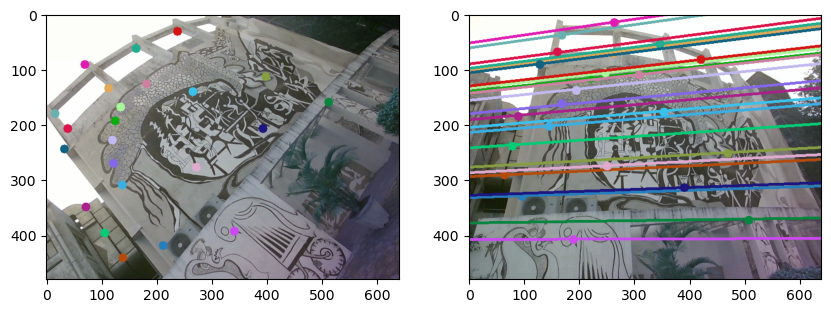

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (10,10)) 
ax = np.reshape(ax, (-1,))
img_annotated_1, img_annotated_2, lines_in_image_2 = img_helper.plot_epipolar_lines(img_1,img_2,px_df_1, px_df_2, F_want )
ax[0].imshow(img_annotated_1)
ax[1].imshow(img_annotated_2)

#### Plotting epipolar lines in image 1

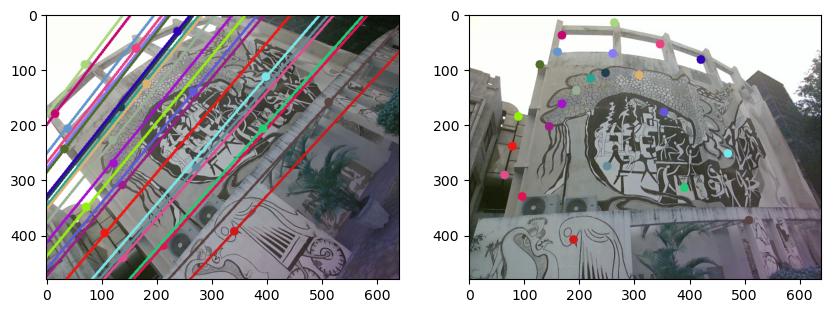

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (10,10)) 
ax = np.reshape(ax, (-1,))
img_annotated_2, img_annotated_1, lines_in_image_1 = img_helper.plot_epipolar_lines(img_2,img_1,px_df_2, px_df_1, F_want.T )
ax[0].imshow(img_annotated_1)
ax[1].imshow(img_annotated_2)

## ----------------------------------------------------------------------

## TODO 3:

## Q) 3. Report the location of the epipoles. Mathematically find the epipoles and verify that the epipolar lines intersect at the epipole. What happens to epipole in case Fundamental matrix is not full rank?

#### Ans:

If **F has a full rank** then it will have an empty null-space i.e. it won’t have any point that is on entire set of lines. This can be seen by the rank nullity theorem.
If rank(F) = 3, then null space of F will contain the trivial solution 0 only.
As a result of this, no point $d$ would exist on the 2nd image which satisfies $d \times F \times x = 0$ for all $x$ in the first image. This would mean that no epipole exists on the 2nd image. Likewise u, would be true for $F^T$ as well.

If the fundamental matrix is **NOT full-rank**, then:
* If **rank(F) = 2**, then a unique epipole would exist
* If **rank(F) = 1**, then many different epipoles would exist as the null-space's basis would have size 2. Hence, such a condition is unlikely to occur.


#### Find the null space

In [46]:
from scipy.linalg import null_space

___________________

In [47]:
with np.printoptions(suppress=True):
    print(lines_in_image_2[0])

[0.00386509110383276, 0.027238300278964456, -1.6799780420241426]


In [48]:
with np.printoptions(suppress=True):
    print(lines_in_image_1[0])

[-0.019264720967998947, -0.014730698485630828, 2.9641739369219424]


### Finding epipole in image 1:
$x'^T \times F \times d = 0$ for all $x'^T$ in image 2

Which means that $d$ should lie in null space of $F$

In [49]:
ns1 = null_space(F_want)

In [50]:
ns1/=ns1[-1,-1]
ns1 = ns1.T[0]

In [51]:
epipole_in_img_1 = ns1
with np.printoptions(suppress=True):
    print("Epipole in image 1 is: ",epipole_in_img_1)

Epipole in image 1 is:  [-2536.21177864  3518.06713162     1.        ]


#### We can find perpendicular distance for epipole in image 1 with all epipolar lines in image 1

In [52]:
perpendicular_dist_arr = []
for curr_line in lines_in_image_1:
    
    # normalize the line coordinates
    curr_line = curr_line/np.linalg.norm(curr_line)
    dist = np.dot(curr_line,epipole_in_img_1 )
    perpendicular_dist_arr.append(np.abs(dist))
perpendicular_dist_arr = np.array(perpendicular_dist_arr)

In [53]:
with np.printoptions(suppress=True):
    print("Mean distance of epipole in image 1 with epipolar lines is:\n ", perpendicular_dist_arr.mean())

Mean distance of epipole in image 1 with epipolar lines is:
  7.360295947601907e-14


### Finding epipole in image 2:
$x^T \times F^T \times d = 0$ for all $x^T$ in image 1

Which means that $d$ should lie in null space of $F^T$

In [54]:
ns2 = null_space(F_want.T)

In [55]:
ns2/=ns2[-1,-1]
ns2 = ns2.T[0]

In [56]:
epipole_in_img_2 = ns2
with np.printoptions(suppress=True):
    print("Epipole in image 2 is: ",epipole_in_img_2)

Epipole in image 2 is:  [-2491.1978791    415.17586217     1.        ]


In [57]:
perpendicular_dist_arr = []
for curr_line in lines_in_image_2:
    
    # normalize the line coordinates
    curr_line = curr_line/np.linalg.norm(curr_line)
    dist = np.dot(curr_line,epipole_in_img_2 )
    perpendicular_dist_arr.append(np.abs(dist))
perpendicular_dist_arr = np.array(perpendicular_dist_arr)

In [58]:
print("Mean distance of epipole in image 2 with epipolar lines is: \n", perpendicular_dist_arr.mean())

Mean distance of epipole in image 2 with epipolar lines is: 
 6.152566379074889e-14


## -----------------------------------------------------------------

## TODO 4:


4. Compute all 4 possible solutions of rotation matrix `R` and translation `C` between the two camera's that could be used to obtain the same essential/fundamental matrix by implementing following function: `[R1 C1 R2 C2 R3 C3 R4 C4] = CameraPose(F, K)`; where `F` is the fundamental matrix and `K` is the intrinsic parameter. 

    <img src="./data/2/camera_orientation.png" alt="image 1" width="800"/> <br>


#### Declaring the k matrix as per the parameters given in the `\data\2 folder`

In [59]:
import helper_utils.dlt_related as dlt_related
importlib.reload(dlt_related)
import helper_utils.annotate_images as img_helper
importlib.reload(img_helper)
import helper_utils.estimation_related as est_related
importlib.reload(est_related)

<module 'helper_utils.estimation_related' from '/home/anmolagarwal/Desktop/mr_assignment_3/helper_utils/estimation_related.py'>

In [60]:
f_x = 382.1996765136719
f_y = 381.83956909
c_x = 312.7102355957031
c_y = 247.72047424316406
scaling_fac = 1000.0

K_mat = np.array([
    [f_x, scaling_fac, c_x],
    [0, f_y, c_y],
    [0, 0, 1]
    
])

In [61]:
with np.printoptions(suppress=True):
    print('\nFundamental matrix:\n', F_want)
    print('\nIntrisnic K matrix is:\n', K_mat)


Fundamental matrix:
 [[-0.00000727 -0.00000672  0.00519099]
 [-0.00000021 -0.00000832  0.02873913]
 [-0.01803474 -0.01328568  1.        ]]

Intrisnic K matrix is:
 [[ 382.19967651 1000.          312.7102356 ]
 [   0.          381.83956909  247.72047424]
 [   0.            0.            1.        ]]


#### Computing essential matrix from fundamental matrix

$E := K^T \times F \times K$   

where $K$ is the camera calibration matrix or camera intrinsic matrix

Due to noise in $K$, it is possible that $E$ is full-rank. In order to enforce rank(E)=2, it's last singular value can again be set to zero



* The essential matrix, E = [t] × R, has **only five degrees of freedom**: both the rotation matrix R and the translation t have three degrees of freedom, but there is an **overall scale ambiguity** – like the fundamental matrix, the essential matrix is a homogeneous quantity.
* Essential matrix is: E = $[t]_x R$

**The proof of my approach can be found in: Zisserman's book: `Results 9.17 & 9.18.` and `Section 9.6.2`** and also in the `docs/four_pose_decomposition_proof.pdf` folder

#### Find essential matrix from fundamental matrix

In [62]:
essential_matrix = est_related.essential_from_fundamental(F_want, K_mat)

In [63]:
with np.printoptions(suppress=True):
    print('\nEssential matrix is:\n', essential_matrix    )


Essential matrix is:
 [[-0.03455538 -0.12210583  0.01387346]
 [-0.05221996 -0.29337106  0.9531935 ]
 [-0.27025556 -0.90724834 -0.30032424]]


In [64]:
R_candidates, C_candidates = est_related.FetchCameraPose(F_want, K_mat)

In [65]:
R1, R2, R3, R4 = R_candidates
C1, C2, C3, C4 = C_candidates

In [66]:
with np.printoptions(suppress=True):
    print(f"Contender 1 is: \nR:\n {R1}\nC:\n{C1}")
    print("########")
with np.printoptions(suppress=True):
    print(f"Contender 2 is: \nR:\n {R2}\nC:\n{C2}")
    print("########")
with np.printoptions(suppress=True):
    print(f"Contender 3 is: \nR:\n {R3}\nC:\n{C3}")
    print("########")
with np.printoptions(suppress=True):
    print(f"Contender 4 is: \nR:\n {R4}\nC:\n{C4}")
    print("########")

Contender 1 is: 
R:
 [[ 0.94513855 -0.28550598 -0.15874338]
 [-0.32134227 -0.89997363 -0.29459569]
 [-0.05875603  0.3294447  -0.9423449 ]]
C:
[-0.99181834  0.05127036  0.11690907]
########
Contender 2 is: 
R:
 [[ 0.94513855 -0.28550598 -0.15874338]
 [-0.32134227 -0.89997363 -0.29459569]
 [-0.05875603  0.3294447  -0.9423449 ]]
C:
[ 0.99181834 -0.05127036 -0.11690907]
########
Contender 3 is: 
R:
 [[ 0.96064078 -0.26107155  0.09492601]
 [ 0.22282625  0.92822802  0.29789462]
 [-0.16588479 -0.26501771  0.94986728]]
C:
[-0.99181834  0.05127036  0.11690907]
########
Contender 4 is: 
R:
 [[ 0.96064078 -0.26107155  0.09492601]
 [ 0.22282625  0.92822802  0.29789462]
 [-0.16588479 -0.26501771  0.94986728]]
C:
[ 0.99181834 -0.05127036 -0.11690907]
########


#### Store data for disambiguation.ipynb

In [67]:
store_data = dict()
store_data["F_want"] = F_want
store_data["E_matrix"] = F_want
store_data["R_candidates"] = R_candidates
store_data["C_candidates"] = C_candidates
store_data["K_mat"] = K_mat
with open('./saved_data/details.pickle', 'wb') as handle:
    pickle.dump(store_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

## --------------------------------------------------------


5. **Triangulation:** Given four configurations of relative camera pose, you will find the best camera pose by verifying through 3D point triangulation. Follow the below steps for the same:


### TODO: 5
1. Linear triangulation: Write a code that computes the 3D point given the correspondence, u ↔ v, and two camera projection matrices i.e. `[X] = LinearTriangulation(P1,u,P2,v)` Input: `P1, P2 ∈ R3×4` are two camera projection matrices, and `u ↔ v ∈ R2` are their 2D correspondence. Output: `X ∈ R3` is the triangulated 3D point. 


#### My notes:
Triangulation allows us to disambiguate four camera pose configuration obtained from the essential matrix.

##### Goal:
Given two camera poses, (C1, R1) and (C2, R2), and correspondences x1 ↔ x2, triangulate 3D
points using linear least squares.


## TODO 5 can be found in `triangulation.ipynb`
## TODOs 6 and 7  can be found in `cheirality_stuff.ipynb` and `disambiguation.ipynb` respectively

## ----------------------------------------------------

### TODO 6:


2. What is cheirality condition and it's importance? Implement the following function for checking cheirality. `idx = CheckCheirality(Y,C,R)` Input: `Y` is a `n × 3` matrix that includes `n` 3D points, and `C,R` is the relative camera pose being checked(camera center and rotation). Output: `idx` is a set of indices of 3D points that satisfy cheirality.


### TODO 7:


3. Based on cheirality, find the correct relative camera pose and clearly mention the same. Visualize 3D camera pose and 3D points together(It's up to you how you come with visualisation).
    